****This Jupyter notebook describes the process of the process of making the synthesized dataset for the experiments****

The satellite imageries are collected from: https://github.com/conorosully/landsat-coastline-segmentation

In [1]:
import os
import sys
import numpy as np
import pickle
import random
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import stats
from scipy.integrate import odeint

In [2]:
width = 256
height = 256
num_bands = 7
img_dir = 'data/LICS/'

### The selected images are those covers both land and water

In [3]:
with open('data/selected_files.pkl', 'rb') as f:
    selected_files = pickle.load(f)

In [71]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Get all image file names
img_files = [os.path.join(img_dir, f) for f in selected_files]

# Load images and extract first 7 bands
image_features = []
for file in img_files:
    img = np.load(file)  # Shape: (256, 256, 8)
    img_flatten = img[:, :, :7].reshape(-1)  # Shape: (7, 256*256)
    image_features.append(img_flatten)

img_features = np.vstack(image_features)  # Shape: (num_images, 7)

In [72]:
# Perform PCA to extract 10 components
pca = PCA(n_components=10, svd_solver='randomized', random_state=8787)
pca_result = pca.fit_transform(img_features) 

# Now scale the PCA result (mean=0, std=1)
scaler = StandardScaler()
pca_result_scaled = scaler.fit_transform(pca_result)  # Scaled result

with open('data/selected_files.pkl', 'wb') as f:
    pickle.dump(pca_result_scaled, f)

In [13]:
with open('data/selected_files.pkl', 'rb') as f:
    pca_result_scaled = pickle.load(f)

### Simulate the dark vessels 


---

# Estimating Vessel Density in Coastal Ecosystems

The `estimate_vessel_density` function simulates vessel presence in coastal waters by modeling fish population density and coastal characteristics from satellite imagery. This supports the detection of dark vessels (unreported fishing vessels) as part of the analysis in Section \ref{sec:mos} of the research paper. The function integrates environmental factors like sea surface temperature (SST), turbidity, and chlorophyll with spatial coastal features to estimate vessel density per pixel.

## Function Definition

```python
estimate_vessel_density(bands, aux_vars, coeff, water_mask)

In [10]:
import numpy as np
from scipy import ndimage

def estimate_vessel_density(bands, aux_vars, coeff, water_mask):
    """
    Estimate vessel and dark vessel presence per pixel based on fish population and coastal characteristics.
    
    Parameters:
        bands : numpy array (height, width, 7)
            Contains B, G, R, NIR, and thermal bands.
        aux_vars : numpy array
            Auxiliary variables (e.g., depth, salinity).
        coeff : numpy array
            Coefficients for auxiliary variables.
        water_mask : numpy array (boolean)
            True indicates water pixels.
    
    Returns:
        vessel : numpy array
            Binary array (1 = vessel present, 0 = none).
        dark_vessel : numpy array
            Binary array (1 = dark vessel, 0 = reported or none).
    """
    # Extract bands
    B, G, R, NIR, _, _, T = [bands[:, :, i].astype(float) for i in range(7)]
    
    # --- Fish Population Estimation ---
    SST = (T * 0.04) - 273.15
    
    # Turbidity with safeguards
    numerator = R + G
    denominator = R - G + 0.01
    ratio = np.maximum(numerator, 0.01) / np.maximum(denominator, 0.01)
    turbidity = np.log(ratio)
    turbidity = np.nan_to_num(turbidity, nan=0.0, posinf=10.0, neginf=0.0)
    
    # Chlorophyll with safeguards
    chlor_ratio = np.maximum(B / (NIR + 0.01), 0.01)
    chlorophyll = 10 ** (0.319 - 2.336 * np.log(chlor_ratio) + 
                        0.879 * (np.log(chlor_ratio))**2)
    chlorophyll = np.nan_to_num(chlorophyll, nan=0.0, posinf=50.0, neginf=0.0)
    
    # Normalize factors
    sst_norm = np.clip((SST - 15) / (30 - 15), 0, 1)
    turb_norm = np.clip(turbidity / 10, 0, 1)
    chlor_norm = np.clip(chlorophyll / 50, 0, 1)
    
    fish_prob = (sst_norm * (1 - np.abs(sst_norm - 0.5)) * 2 + 
                 turb_norm * (1 - np.abs(turb_norm - 0.5)) * 2 + 
                 chlor_norm) / 3
    
    fish_pop = 1000 / (1 + np.exp(-5 * (fish_prob - 0.5)))
    fish_pop = np.clip(fish_pop, 0, 10000) * water_mask
    
    # --- Coastal Characteristics ---
    coast = water_mask ^ ndimage.binary_erosion(water_mask)
    coastal_influence = ndimage.gaussian_filter(coast.astype(float), sigma=2.0)
    ci_max = np.max(coastal_influence)
    coastal_influence_norm = np.clip(
        coastal_influence / ci_max if ci_max > 0 else coastal_influence, 0, 1)
    distance = ndimage.distance_transform_edt(~coast)
    distance_effect = np.exp(-distance / 20.0)
    
    # --- Vessel Probability ---
    vessel_prob = (0.005 * (fish_pop / 10000) + 
                   0.003 * distance_effect + 
                   0.002 * coastal_influence_norm)
    vessel_prob = np.clip(vessel_prob, 0, 1) * water_mask  # Ensure water-only
    vessel_prob = np.nan_to_num(vessel_prob, nan=0.0)  # Remove any NaNs
    
    # Sample vessel presence
    vessel = np.random.binomial(1, vessel_prob)
    
    # --- Dark Vessel Probability ---
    aux_impact = np.sum(aux_vars * coeff)
    alpha = np.exp(aux_impact)
    dark_vessel_prob = np.random.beta(alpha, 2, size=vessel.shape)
    dark_vessel_prob = np.clip(dark_vessel_prob, 0, 1)
    dark_vessel_prob = np.nan_to_num(dark_vessel_prob, nan=0.0)
    
    # Dark vessels only where vessels exist
    dark_vessel = vessel * np.random.binomial(1, dark_vessel_prob)
    
    return fish_pop, vessel, dark_vessel

#### See one example

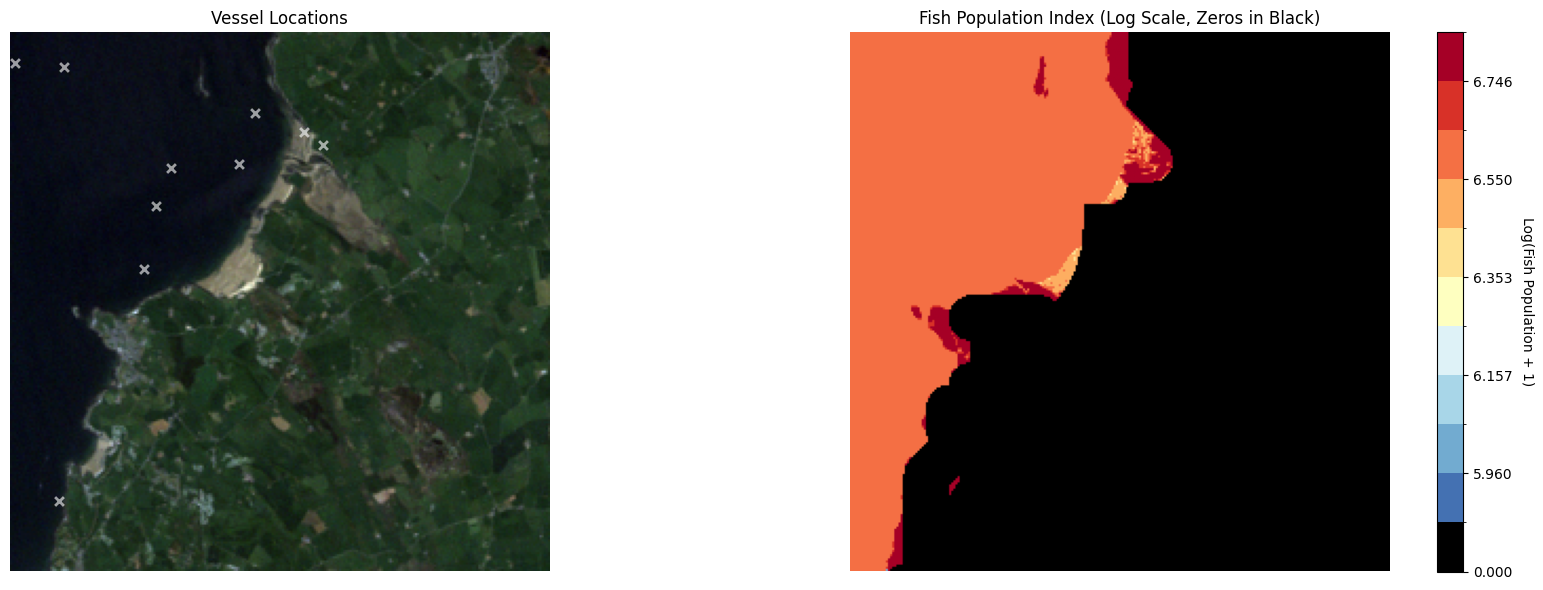

In [20]:
# Create the figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# First subplot: RGB image (unchanged)
axes[0].imshow(rgb_normalized)

# Get coordinates of detected vessels
y_coords, x_coords = np.where(vessel == 1)
axes[0].scatter(x_coords, y_coords, color='white', s=40, alpha=0.6, marker='x', linewidths=2)  # White dots for all vessels

# Get coordinates of detected dark vessels
y_coords, x_coords = np.where(dark_vessel == 1)
axes[0].scatter(x_coords, y_coords, color='red', s=40, alpha=0.6, marker='x', linewidths=2)  # Red dots for dark vessels
axes[0].set_title('Vessel Locations')
axes[0].axis("off")

# Second subplot: Fish population index with log transformation and black for zeros
# Apply log transformation to fish_pop (add a small constant to avoid log(0))
fish_pop_log = np.log1p(fish_pop)  # np.log1p(x) computes log(1 + x)

# Mask to separate zero and non-zero regions
non_zero_mask = fish_pop > 0  # Boolean mask where fish_pop is non-zero
fish_pop_log_masked = fish_pop_log.copy()
fish_pop_log_masked[~non_zero_mask] = np.nan  # Set zero regions to NaN for colormap

# Create a custom colormap: black for zeros, then a diverging scale for non-zeros
from matplotlib.colors import ListedColormap, BoundaryNorm
cmap = plt.get_cmap('RdYlBu_r')  # Base diverging colormap
colors = cmap(np.linspace(0, 1, 256))  # Extract colors
new_colors = np.vstack(([0, 0, 0, 1], colors))  # Prepend black (RGBA) for zeros
custom_cmap = ListedColormap(new_colors)

# Define boundaries: 0 gets black, then log-transformed non-zero values
bounds = [0, 1e-6] + list(np.linspace(np.min(fish_pop_log[non_zero_mask]), np.max(fish_pop_log), 10))
norm = BoundaryNorm(bounds, custom_cmap.N)

# Plot the fish population with the custom colormap
im1 = axes[1].imshow(fish_pop_log, cmap=custom_cmap, norm=norm, origin='upper')
axes[1].set_title('Fish Population Index (Log Scale, Zeros in Black)')
cbar = fig.colorbar(im1, ax=axes[1], label='Log(Fish Population + 1)')
cbar.set_label('Log(Fish Population + 1)', rotation=270, labelpad=15)
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [251]:
random.seed(8787)
np.random.seed(8787)

# sample parameters
coeff = np.random.normal(size = 10) # sample coefficients

simulated_meta = []
shuffled_indices = np.random.permutation(len(selected_files))

for i in range(1200):
    img_i = shuffled_indices[i]
    covs = pca_result_scaled[img_i, :]  # get image covs

    f_img_path = os.path.join(img_dir, os.listdir(img_dir)[img_i])
    img = np.load(f_img_path)
    bands = img[:, :, :7]
    mask = img[:, :, 7]
    
    f_fish_pop, f_vessel, f_dark_vessel = estimate_vessel_density(bands, covs, coeff, mask)

    y_f = f_dark_vessel.sum()

    img_i = shuffled_indices[i + 1200]
    cf_img_path = os.path.join(img_dir, os.listdir(img_dir)[img_i])
    img = np.load(cf_img_path)
    bands = img[:, :, :7]
    mask = img[:, :, 7]
    
    cf_fish_pop, cf_vessel, cf_dark_vessel = estimate_vessel_density(bands, covs, coeff, mask)

    y_cf = cf_dark_vessel.sum()

    data = {'covs': covs,
            'f_img_path': f_img_path,
            'f_fish_pop': f_fish_pop,
            'f_vessel': f_vessel,
            'f_dark_vessel': f_dark_vessel,
            'y_f': y_f,
            'cf_img_path': cf_img_path,
            'cf_fish_pop': cf_fish_pop,
            'cf_vessel': cf_vessel,
            'cf_dark_vessel': cf_dark_vessel,
            'y_cf': y_cf}
    
    simulated_meta.append(data)
    
    if len(simulated_meta) % 50 == 0:
        print(f"{len(simulated_meta)} / 1200 finished")

50 / 1200 finished
100 / 1200 finished
150 / 1200 finished
200 / 1200 finished
250 / 1200 finished
300 / 1200 finished
350 / 1200 finished
400 / 1200 finished
450 / 1200 finished
500 / 1200 finished
550 / 1200 finished
600 / 1200 finished
650 / 1200 finished
700 / 1200 finished
750 / 1200 finished
800 / 1200 finished
850 / 1200 finished
900 / 1200 finished
950 / 1200 finished
1000 / 1200 finished
1050 / 1200 finished
1100 / 1200 finished
1150 / 1200 finished
1200 / 1200 finished


In [5]:
with open('data/dark_vessel_simulated_meta.pkl', 'rb') as f:
    simulated_meta = pickle.load(f)

data/LICS/LC08_L2SP_205024_20230420_20230429_02_T1_181.npy
6 dark vessels / 7 total vessels


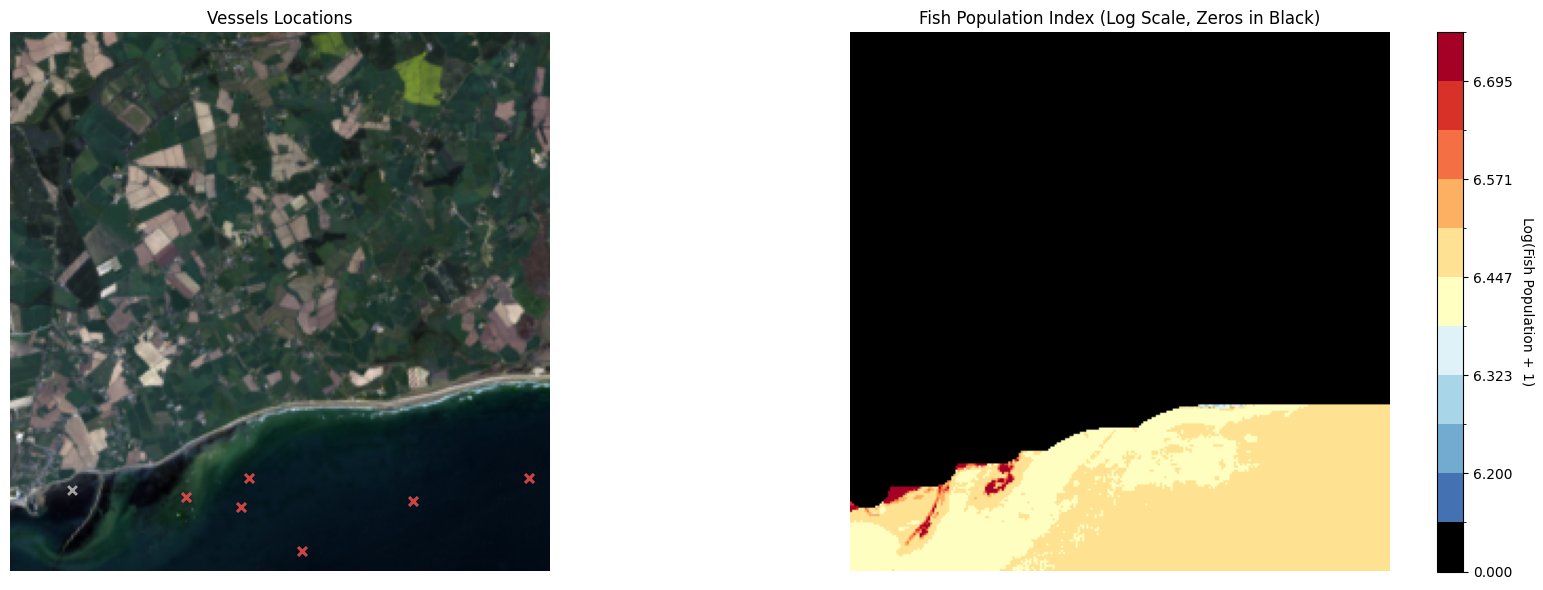

data/LICS/LC08_L2SP_205023_20200529_20200820_02_T1_88.npy
35 dark vessels / 42 total vessels


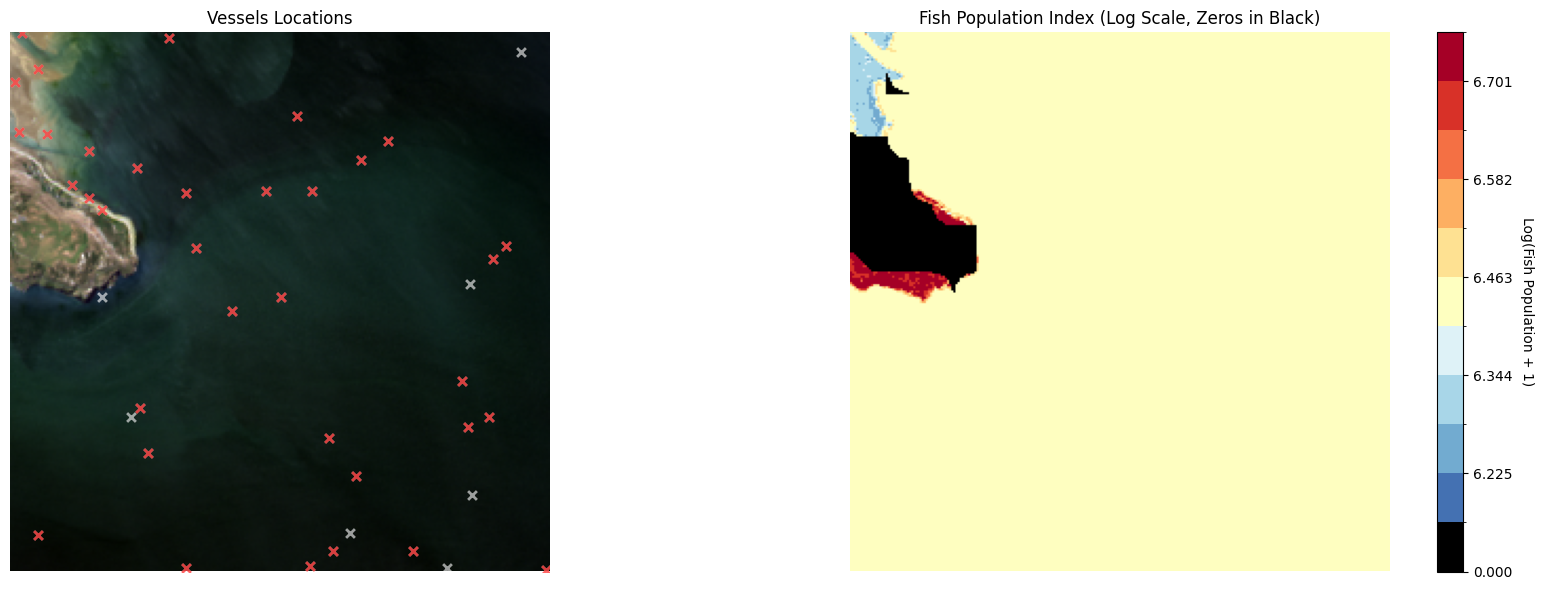

In [22]:
i = 296    

img = np.load(simulated_meta[i]['f_img_path'])

print(simulated_meta[i]['f_img_path'])

fish_pop = simulated_meta[i]['f_fish_pop']
vessel = simulated_meta[i]['f_vessel']
dark_vessel = simulated_meta[i]['f_dark_vessel']

print(f'{dark_vessel.sum()} dark vessels / {vessel.sum()} total vessels')

# Split into R, G, B bands
rgb = img[:, :, [2, 1, 0]]
red = rgb[:, :, 0]    # (256, 256)
green = rgb[:, :, 1]  # (256, 256)
blue = rgb[:, :, 2]   # (256, 256)

# Normalize each band to [0, 1]
red_normalized = (red - red.min()) / (red.max() - red.min() + 1e-6)    # Add small value to avoid division by zero
green_normalized = (green - green.min()) / (green.max() - green.min() + 1e-6)
blue_normalized = (blue - blue.min()) / (blue.max() - blue.min() + 1e-6)

# Stack back into (256, 256, 3)
rgb_normalized = np.stack([red_normalized, green_normalized, blue_normalized], axis=2)

# Create the figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# First subplot: RGB image
axes[0].imshow(rgb_normalized)

# Get coordinates of detected dark vessels
y_coords, x_coords = np.where(vessel == 1)

axes[0].scatter(x_coords, y_coords, color='white', s=40, alpha=0.6, marker = 'x', linewidths=2)  # Red dots for dark vessels
axes[0].set_title('Vessels Locations')

# Get coordinates of detected dark vessels
y_coords, x_coords = np.where(dark_vessel == 1)

axes[0].scatter(x_coords, y_coords, color='red', s=40, alpha=0.6, marker = 'x', linewidths=2)  # Red dots for dark vessels
axes[0].axis("off")

# Second subplot: Fish population index
# Apply log transformation to fish_pop (add a small constant to avoid log(0))
fish_pop_log = np.log1p(fish_pop)  # np.log1p(x) computes log(1 + x)

# Mask to separate zero and non-zero regions
non_zero_mask = fish_pop > 0  # Boolean mask where fish_pop is non-zero
fish_pop_log_masked = fish_pop_log.copy()
fish_pop_log_masked[~non_zero_mask] = np.nan  # Set zero regions to NaN for colormap

# Create a custom colormap: black for zeros, then a diverging scale for non-zeros
from matplotlib.colors import ListedColormap, BoundaryNorm
cmap = plt.get_cmap('RdYlBu_r')  # Base diverging colormap
colors = cmap(np.linspace(0, 1, 256))  # Extract colors
new_colors = np.vstack(([0, 0, 0, 1], colors))  # Prepend black (RGBA) for zeros
custom_cmap = ListedColormap(new_colors)

# Define boundaries: 0 gets black, then log-transformed non-zero values
bounds = [0, 1e-6] + list(np.linspace(np.min(fish_pop_log[non_zero_mask]), np.max(fish_pop_log), 10))
norm = BoundaryNorm(bounds, custom_cmap.N)

# Plot the fish population with the custom colormap
im1 = axes[1].imshow(fish_pop_log, cmap=custom_cmap, norm=norm, origin='upper')
axes[1].set_title('Fish Population Index (Log Scale, Zeros in Black)')
cbar = fig.colorbar(im1, ax=axes[1], label='Log(Fish Population + 1)')
cbar.set_label('Log(Fish Population + 1)', rotation=270, labelpad=15)
axes[1].axis("off")

plt.tight_layout()
plt.show()

img = np.load(simulated_meta[i]['cf_img_path'])

print(simulated_meta[i]['cf_img_path'])

fish_pop = simulated_meta[i]['cf_fish_pop']
vessel = simulated_meta[i]['cf_vessel']
dark_vessel = simulated_meta[i]['cf_dark_vessel']

print(f'{dark_vessel.sum()} dark vessels / {vessel.sum()} total vessels')

# Split into R, G, B bands
rgb = img[:, :, [2, 1, 0]]
red = rgb[:, :, 0]    # (256, 256)
green = rgb[:, :, 1]  # (256, 256)
blue = rgb[:, :, 2]   # (256, 256)

# Normalize each band to [0, 1]
red_normalized = (red - red.min()) / (red.max() - red.min() + 1e-6)    # Add small value to avoid division by zero
green_normalized = (green - green.min()) / (green.max() - green.min() + 1e-6)
blue_normalized = (blue - blue.min()) / (blue.max() - blue.min() + 1e-6)

# Stack back into (256, 256, 3)
rgb_normalized = np.stack([red_normalized, green_normalized, blue_normalized], axis=2)

# Create the figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# First subplot: RGB image
axes[0].imshow(rgb_normalized)

# Get coordinates of detected dark vessels
y_coords, x_coords = np.where(vessel == 1)

axes[0].scatter(x_coords, y_coords, color='white', s=40, alpha=0.6, marker = 'x', linewidths=2)  # Red dots for dark vessels
axes[0].set_title('Vessels Locations')

# Get coordinates of detected dark vessels
y_coords, x_coords = np.where(dark_vessel == 1)

axes[0].scatter(x_coords, y_coords, color='red', s=40, alpha=0.6, marker = 'x', linewidths=2)  # Red dots for dark vessels
axes[0].axis("off")

# Second subplot: Fish population index
# Apply log transformation to fish_pop (add a small constant to avoid log(0))
fish_pop_log = np.log1p(fish_pop)  # np.log1p(x) computes log(1 + x)

# Mask to separate zero and non-zero regions
non_zero_mask = fish_pop > 0  # Boolean mask where fish_pop is non-zero
fish_pop_log_masked = fish_pop_log.copy()
fish_pop_log_masked[~non_zero_mask] = np.nan  # Set zero regions to NaN for colormap

# Create a custom colormap: black for zeros, then a diverging scale for non-zeros
from matplotlib.colors import ListedColormap, BoundaryNorm
cmap = plt.get_cmap('RdYlBu_r')  # Base diverging colormap
colors = cmap(np.linspace(0, 1, 256))  # Extract colors
new_colors = np.vstack(([0, 0, 0, 1], colors))  # Prepend black (RGBA) for zeros
custom_cmap = ListedColormap(new_colors)

# Define boundaries: 0 gets black, then log-transformed non-zero values
bounds = [0, 1e-6] + list(np.linspace(np.min(fish_pop_log[non_zero_mask]), np.max(fish_pop_log), 10))
norm = BoundaryNorm(bounds, custom_cmap.N)

# Plot the fish population with the custom colormap
im1 = axes[1].imshow(fish_pop_log, cmap=custom_cmap, norm=norm, origin='upper')
axes[1].set_title('Fish Population Index (Log Scale, Zeros in Black)')
cbar = fig.colorbar(im1, ax=axes[1], label='Log(Fish Population + 1)')
cbar.set_label('Log(Fish Population + 1)', rotation=270, labelpad=15)
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [268]:
import pickle
with open('data/dark_vessel_simulated_meta.pkl', 'wb') as f:
    pickle.dump(simulated_meta, f)